# Traffic Ticket Quotas in Seattle
## Agustin Lew
## 12/10/2019
## HCDE512

### Import required libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopy
import geopy.distance
import gmplot

### Load data from the raw_data folder 

In [2]:
%pwd

'/home/ablew/hcde512/hw/final-project/src'

In [3]:
%cd ..

/home/ablew/hcde512/hw/final-project


In [4]:
home_directory = %pwd

In [5]:
%cd src

/home/ablew/hcde512/hw/final-project/src


In [6]:
df_seattle = pd.read_csv(home_directory + '/raw_data/wa_seattle_2019_08_13.csv')
df_seattle.head()

/home/ablew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,11,20,21,22,23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,raw_row_number,date,time,location,lat,lng,beat,precinct,sector,subject_age,...,citation_issued,warning_issued,outcome,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state,vehicle_year,raw_type_description,raw_vehicle_description
0,1,2006-01-01,02:19:37,15 NE/NE 50,47.664980,-122.327990,B3,N,B,20.0,...,False,False,arrest,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2006-01-02,02:23:42,1100-blk E CHERRY,47.607213,-122.323142,E3,E,E,NaN,...,False,False,arrest,NaN,NaN,NaN,NaN,NaN,TRAFFIC - MOVING VIOLATION,NaN
2,3,2006-01-02,04:16:42,5000-blk SW HINDS ST,47.573903,-122.396095,W1,SW,W,NaN,...,False,False,arrest,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2006-01-03,01:08:48,100 PINE #BLK,47.609824,-122.340936,M1,W,M,NaN,...,False,False,arrest,NaN,NaN,NaN,NaN,NaN,TRAFFIC STOP - OFFICER INITIATED ONVIEW,NaN
4,5,2006-01-06,21:41:34,DENNY WY/DEXTER AV,47.618942,-122.342300,D2,W,D,NaN,...,False,False,arrest,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Information on raw data

In [7]:
print("The raw dataframe has " + str(len(df_seattle)) + " rows and " + str(len(df_seattle.columns)) + " columns.")

The raw dataframe has 319959 rows and 27 columns.


In [8]:
print("The dataset has " + str(df_seattle.officer_id_hash.nunique()) + " unique officers.")

The dataset has 1652 unique officers.


##### Column names and types

In [9]:
df_seattle.dtypes

raw_row_number                  int64
date                           object
time                           object
location                       object
lat                           float64
lng                           float64
beat                           object
precinct                       object
sector                         object
subject_age                   float64
subject_race                   object
subject_sex                    object
officer_id_hash                object
type                           object
disposition                    object
violation                      object
arrest_made                      bool
citation_issued                  bool
warning_issued                   bool
outcome                        object
vehicle_color                  object
vehicle_make                   object
vehicle_model                  object
vehicle_registration_state     object
vehicle_year                  float64
raw_type_description           object
raw_vehicle_

### Data cleaning
* Removed missing values for the columns 'officer_id_hash', 'date', 'time', 'lat'
* Changed date and time columns to pandas datetime type
* Included only records newer than 2013-01-01
* Included only vehicular traffic stops
* Selected columns: date, time, lat, lng, officer_id_hash, type, citation_issued, warning_issued, outcome, raw_type_description

In [10]:
df_seattle = df_seattle[~df_seattle.officer_id_hash.isna()]
df_seattle = df_seattle[~df_seattle.time.isna()]
df_seattle = df_seattle[~df_seattle.date.isna()]
df_seattle = df_seattle[~df_seattle.lat.isna()]
df_seattle['date'] = pd.to_datetime(df_seattle['date'], errors='coerce')
df_seattle['time'] = pd.to_datetime(df_seattle['time'], format='%H:%M:%S', errors='coerce')
df_seattle = df_seattle[df_seattle.date >= '2013-01-01']
df_seattle = df_seattle[['date', 'time', 'lat', 'lng', 'officer_id_hash', 'type', 'citation_issued', 'warning_issued', 'outcome', 'raw_type_description']]
df_seattle = df_seattle[df_seattle.type == 'vehicular']
df_seattle.head()

,date,time,lat,lng,officer_id_hash,type,citation_issued,warning_issued,outcome,raw_type_description
248923,2013-01-01,1900-01-01 00:19:56,47.571433,-122.370755,b5dfc2c7ff,vehicular,False,False,arrest,ACC - UNK INJURIES
248924,2013-01-01,1900-01-01 02:05:48,47.692751,-122.347215,03ca5504a2,vehicular,False,False,arrest,ACC - WITH INJURIES (INCLUDES HIT AND RUN)
248925,2013-01-01,1900-01-01 15:14:15,47.616647,-122.327905,c926914e64,vehicular,False,False,arrest,NUISANCE - MISCHIEF
248926,2013-01-02,1900-01-01 01:15:44,47.717764,-122.296216,9ca54e4bf2,vehicular,False,False,arrest,TRAFFIC STOP - OFFICER INITIATED ONVIEW
248927,2013-01-04,1900-01-01 03:47:25,47.609752,-122.337784,a5f30e4f10,vehicular,False,False,arrest,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT"


#### Exports clean dataframe to the src folder

In [11]:
df_seattle.to_csv(home_directory + '/src/clean_seattle.csv', index=False)

#### Precinct coordinates (obtained from Google Maps)
* N = North Precinct
* S = South Precinct
* SW = Southwest Precinct
* E = East Precinct
* W = West Precinct

In [12]:
sw_precinct = (47.536655, -122.361851)
s_precinct = (47.538801, -122.293376)
w_precinct = (47.616313, -122.336638)
e_precinct = (47.615069, -122.317191)
n_precinct = (47.703082, -122.334784)

#### Creates officers dataframe, one row for each officer, showing the average lat/long coordinates, citation_ratio, warning_ratio, and the distance from their average location to each precinct. 
#### Each officer was assigned the closest precinct as their precinct.

In [13]:
# Creates officers dataframe and creates additional columns
df_officers = df_seattle.groupby(df_seattle.officer_id_hash).sum().citation_issued.reset_index()
df_officers['lat'] = df_seattle.groupby(df_seattle.officer_id_hash).mean().reset_index().lat
df_officers['lng'] = df_seattle.groupby(df_seattle.officer_id_hash).mean().reset_index().lng
df_officers['citation_ratio'] = df_seattle.groupby(df_seattle.officer_id_hash).mean().reset_index().citation_issued
df_officers['warning_ratio'] = df_seattle.groupby(df_seattle.officer_id_hash).mean().reset_index().warning_issued

# Calculates distance from the average lat/long values to each precinct
df_officers['S'] = [geopy.distance.geodesic((df_officers.lat.iloc[i], df_officers.lng.iloc[i]), s_precinct).km for i in range(len(df_officers))]
df_officers['SW'] = [geopy.distance.geodesic((df_officers.lat.iloc[i], df_officers.lng.iloc[i]), sw_precinct).km for i in range(len(df_officers))]
df_officers['W'] = [geopy.distance.geodesic((df_officers.lat.iloc[i], df_officers.lng.iloc[i]), w_precinct).km for i in range(len(df_officers))]
df_officers['E'] = [geopy.distance.geodesic((df_officers.lat.iloc[i], df_officers.lng.iloc[i]), e_precinct).km for i in range(len(df_officers))]
df_officers['N'] = [geopy.distance.geodesic((df_officers.lat.iloc[i], df_officers.lng.iloc[i]), n_precinct).km for i in range(len(df_officers))]

precinct_names=['S', 'SW', 'W', 'E', 'N']
precinct_list = []
for i in range(len(df_officers)):
    S = df_officers.S.values[i]
    SW = df_officers.SW.values[i]
    W = df_officers.W.values[i]
    E = df_officers.E.values[i]
    N = df_officers.N.values[i]
    
    precinct_ix = np.argmin([S,SW,W,E,N])
    precinct_list.append(precinct_names[precinct_ix])
    
df_officers['precinct'] = precinct_list

df_officers.head()

,officer_id_hash,citation_issued,lat,lng,citation_ratio,warning_ratio,S,SW,W,E,N,precinct
0,0065f02af8,0.0,47.597566,-122.315221,0.000000,0.500000,6.737219,7.627208,2.633932,1.951647,11.823331,E
1,0092ecd6fd,0.0,47.609669,-122.338265,0.000000,0.600000,8.572554,8.309512,0.748789,1.694378,10.389316,W
2,016606d685,107.0,47.580653,-122.383569,0.264198,0.377778,8.229528,5.157581,5.308081,6.289713,14.097044,SW
3,01dafbd11b,0.0,47.608271,-122.313620,0.000000,0.000000,7.872566,8.750386,1.947921,0.802090,10.660640,E
4,02348f8e11,1.0,47.537088,-122.282653,0.500000,0.000000,0.829480,5.963075,9.699642,9.051068,18.867122,S


In [14]:
str(round(len(df_officers[df_officers.citation_issued == 0]) / df_officers.officer_id_hash.nunique() * 100, 2)) + "% of officers have 0 citations issued."

'37.67% of officers have 0 citations issued.'

#### Exports officer dataframe to the src folder

In [15]:
df_officers.to_csv(home_directory + '/src/officers.csv', index=False)

### Creating time series of different granularities: hourly, daily, weekly, monthly for each officer

In [16]:
daily_timeseries = df_seattle.groupby([df_seattle.officer_id_hash, df_seattle.date]).count().reset_index()[['officer_id_hash', 'date', 'citation_issued']]
daily_timeseries = daily_timeseries.merge(df_officers[['officer_id_hash', 'precinct']], on='officer_id_hash', how='left')
daily_timeseries.head()

,officer_id_hash,date,citation_issued,precinct
0,0065f02af8,2014-10-14,1,E
1,0065f02af8,2015-08-19,1,E
2,0092ecd6fd,2013-01-22,1,W
3,0092ecd6fd,2013-10-25,1,W
4,0092ecd6fd,2014-01-18,1,W


In [17]:
weekly_timeseries = df_seattle.groupby([df_seattle.officer_id_hash, pd.Grouper(key='date', freq='W-MON')]).count().reset_index()[['officer_id_hash', 'date', 'citation_issued']]
weekly_timeseries = weekly_timeseries.merge(df_officers[['officer_id_hash', 'precinct']], on='officer_id_hash', how='left')
weekly_timeseries.head()

,officer_id_hash,date,citation_issued,precinct
0,0065f02af8,2014-10-20,1,E
1,0065f02af8,2015-08-24,1,E
2,0092ecd6fd,2013-01-28,1,W
3,0092ecd6fd,2013-10-28,1,W
4,0092ecd6fd,2014-01-20,1,W


In [18]:
monthly_timeseries = df_seattle.groupby([df_seattle.officer_id_hash, pd.Grouper(key='date', freq='M')]).count().reset_index()[['officer_id_hash', 'date', 'citation_issued']]
monthly_timeseries = monthly_timeseries.merge(df_officers[['officer_id_hash', 'precinct']], on='officer_id_hash', how='left')
monthly_timeseries.head(10)

,officer_id_hash,date,citation_issued,precinct
0,0065f02af8,2014-10-31,1,E
1,0065f02af8,2015-08-31,1,E
2,0092ecd6fd,2013-01-31,1,W
3,0092ecd6fd,2013-10-31,1,W
4,0092ecd6fd,2014-01-31,1,W
5,0092ecd6fd,2014-04-30,1,W
6,0092ecd6fd,2014-11-30,1,W
7,016606d685,2013-01-31,16,SW
8,016606d685,2013-02-28,4,SW
9,016606d685,2013-03-31,9,SW


#### Exports timeseries dataframes of different granularities to the src folder

In [19]:
daily_timeseries.to_csv(home_directory + '/src/daily_ts.csv', index=False)
weekly_timeseries.to_csv(home_directory + '/src/weekly_ts.csv', index=False)
monthly_timeseries.to_csv(home_directory + '/src/monthly_ts.csv', index=False)

### From the time series dataframes, we create new dataframes on the precinct level 

In [20]:
daily_precinct = daily_timeseries.groupby(['precinct','date']).sum().reset_index()
daily_precinct.head()

,precinct,date,citation_issued
0,E,2013-01-01,11
1,E,2013-01-02,15
2,E,2013-01-03,5
3,E,2013-01-04,15
4,E,2013-01-05,9


In [21]:
weekly_precinct = weekly_timeseries.groupby(['precinct', pd.Grouper(key='date', freq='W-MON')]).sum().reset_index()
weekly_precinct.head()

,precinct,date,citation_issued
0,E,2013-01-07,71
1,E,2013-01-14,78
2,E,2013-01-21,98
3,E,2013-01-28,76
4,E,2013-02-04,62


In [22]:
monthly_precinct = monthly_timeseries.groupby(['precinct', pd.Grouper(key='date', freq='M')]).sum().reset_index()
monthly_precinct.head()

,precinct,date,citation_issued
0,E,2013-01-31,352
1,E,2013-02-28,256
2,E,2013-03-31,274
3,E,2013-04-30,218
4,E,2013-05-31,275


In [23]:
daily_precinct.to_csv(home_directory + '/src/daily_precinct.csv', index=False)
weekly_precinct.to_csv(home_directory + '/src/weekly_precinct.csv', index=False)
monthly_precinct.to_csv(home_directory + '/src/monthly_precinct.csv', index=False)

#### Plotting number of monthly citations per precinct

/home/ablew/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Citations per Precinct')

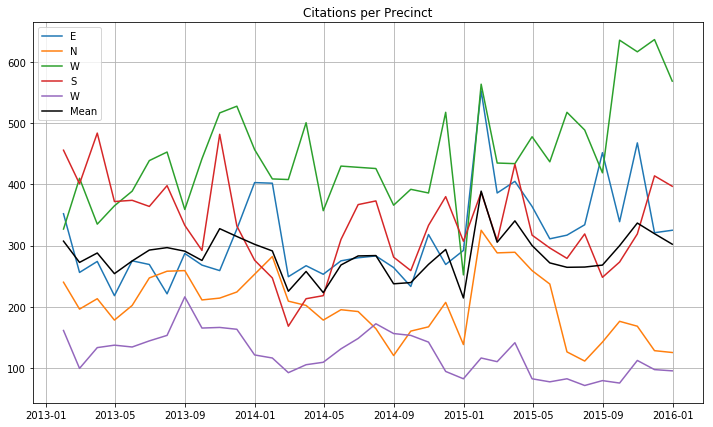

In [24]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(monthly_precinct[monthly_precinct.precinct == 'E'].date,
         monthly_precinct[monthly_precinct.precinct == 'E'].citation_issued,
         label='E')
plt.plot(monthly_precinct[monthly_precinct.precinct == 'N'].date, 
         monthly_precinct[monthly_precinct.precinct == 'N'].citation_issued,
         label='N')
plt.plot(monthly_precinct[monthly_precinct.precinct == 'W'].date, 
         monthly_precinct[monthly_precinct.precinct == 'W'].citation_issued,
         label='W')
plt.plot(monthly_precinct[monthly_precinct.precinct == 'S'].date, 
         monthly_precinct[monthly_precinct.precinct == 'S'].citation_issued,
         label='S')
plt.plot(monthly_precinct[monthly_precinct.precinct == 'SW'].date, 
         monthly_precinct[monthly_precinct.precinct == 'SW'].citation_issued,
         label='W')
plt.plot(monthly_precinct[monthly_precinct.precinct == 'SW'].date, 
         monthly_precinct.groupby(monthly_precinct.date).mean().citation_issued,
         label='Mean', color='black')
plt.legend()
plt.grid()
plt.title('Citations per Precinct')
plt.savefig(home_directory + '/results/citations_precinct.png')
plt.show()

### Periodicity
#### We will check periodicity using autocorrelation plots, resampling to smooth the time series

Text(0.5, 1.0, 'Autocorrelation by Day per Precinct')

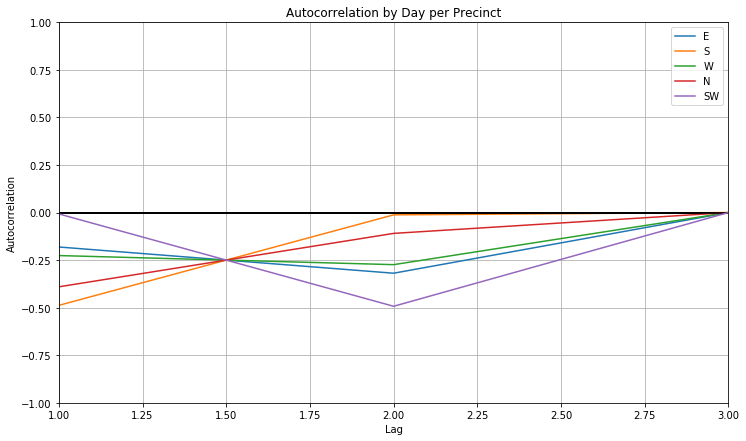

In [25]:
daily_precinct2 = daily_precinct
daily_precinct2 = daily_precinct2.set_index(daily_precinct2.date)

pd.plotting.autocorrelation_plot(daily_precinct2[(daily_precinct2.precinct == 'E')].citation_issued.resample("1y").mean(), label='E')
pd.plotting.autocorrelation_plot(daily_precinct2[(daily_precinct2.precinct == 'S')].citation_issued.resample("1y").mean(), label='S')
pd.plotting.autocorrelation_plot(daily_precinct2[(daily_precinct2.precinct == 'W')].citation_issued.resample("1y").mean(), label='W')
pd.plotting.autocorrelation_plot(daily_precinct2[(daily_precinct2.precinct == 'N')].citation_issued.resample("1y").mean(), label='N')
pd.plotting.autocorrelation_plot(daily_precinct2[(daily_precinct2.precinct == 'SW')].citation_issued.resample("1y").mean(), label='SW')
plt.savefig(home_directory + '/results/autocorrelation_day.png')
plt.title('Autocorrelation by Day per Precinct')

Weak negative autocorrelation every 1.5/2 days. 

Text(0.5, 1.0, 'Autocorrelation by Week per Precinct')

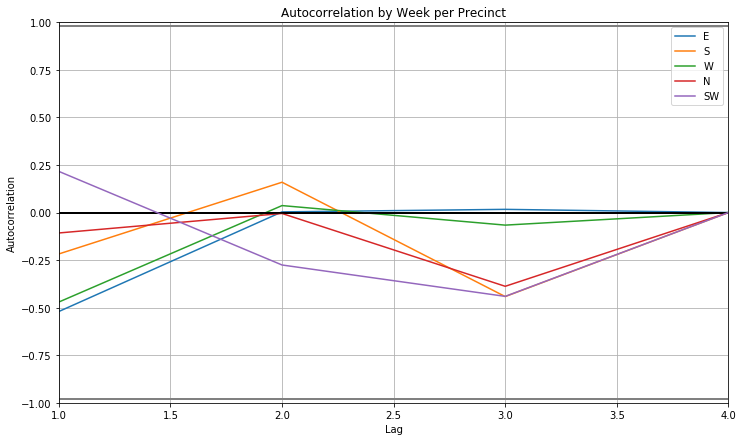

In [26]:
weekly_precinct2 = weekly_precinct
weekly_precinct2 = weekly_precinct2.set_index(weekly_precinct2.date)

pd.plotting.autocorrelation_plot(weekly_precinct2[(weekly_precinct2.precinct == 'E')].citation_issued.resample("1y").mean(), label='E')
pd.plotting.autocorrelation_plot(weekly_precinct2[(weekly_precinct2.precinct == 'S')].citation_issued.resample("1y").mean(), label='S')
pd.plotting.autocorrelation_plot(weekly_precinct2[(weekly_precinct2.precinct == 'W')].citation_issued.resample("1y").mean(), label='W')
pd.plotting.autocorrelation_plot(weekly_precinct2[(weekly_precinct2.precinct == 'N')].citation_issued.resample("1y").mean(), label='N')
pd.plotting.autocorrelation_plot(weekly_precinct2[(weekly_precinct2.precinct == 'SW')].citation_issued.resample("1y").mean(), label='SW')
plt.savefig(home_directory + '/results/autocorrelation_week.png')
plt.title('Autocorrelation by Week per Precinct')

Negative autocorrelation every 3 weeks.

Text(0.5, 1.0, 'Autocorrelation by Month per Precinct')

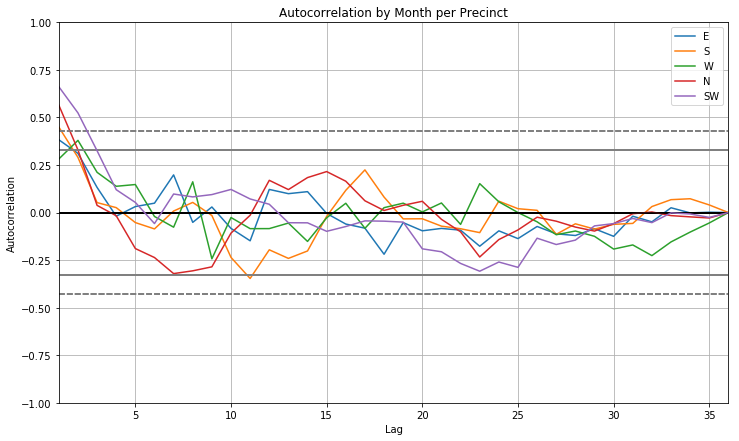

In [27]:
monthly_precinct2 = monthly_precinct
monthly_precinct2 = monthly_precinct2.set_index(monthly_precinct2.date)

pd.plotting.autocorrelation_plot(monthly_precinct2[(monthly_precinct2.precinct == 'E')].citation_issued, label='E')
pd.plotting.autocorrelation_plot(monthly_precinct2[(monthly_precinct2.precinct == 'S')].citation_issued, label='S')
pd.plotting.autocorrelation_plot(monthly_precinct2[(monthly_precinct2.precinct == 'W')].citation_issued, label='W')
pd.plotting.autocorrelation_plot(monthly_precinct2[(monthly_precinct2.precinct == 'N')].citation_issued, label='N')
pd.plotting.autocorrelation_plot(monthly_precinct2[(monthly_precinct2.precinct == 'SW')].citation_issued, label='SW')
plt.savefig(home_directory + '/results/autocorrelation_month.png')
plt.title('Autocorrelation by Month per Precinct')

No autocorrelation for months.

### Hypothetical Quotas
#### For each granularity, we calculate which officers passed the hypothetical ticket quota (range 1-10) at least once.

In [28]:
pass_list_day = []
for i in range(10):
    day_test = daily_timeseries
    day_test['pass'] = day_test.citation_issued > i
    day_test2 = day_test.groupby('officer_id_hash').mean().reset_index()
    pass_list_day.append(len(day_test2[day_test2['pass'] != 0]) / day_test2.officer_id_hash.nunique())

In [29]:
pass_list_week = []
for i in range(10):
    week_test = weekly_timeseries
    week_test['pass'] = week_test.citation_issued > i
    week_test2 = week_test.groupby('officer_id_hash').mean().reset_index()
    pass_list_week.append(len(week_test2[week_test2['pass'] != 0]) / week_test2.officer_id_hash.nunique())

In [30]:
pass_list_month = []
for i in range(10):
    month_test = monthly_timeseries
    month_test['pass'] = month_test.citation_issued > i
    month_test2 = month_test.groupby('officer_id_hash').mean().reset_index()
    pass_list_month.append(len(month_test2[month_test2['pass'] != 0]) / month_test2.officer_id_hash.nunique())

Text(0.5, 1.0, 'Proportion of officers passing quota')

Text(0, 0.5, 'Proportion of officers')

Text(0.5, 0, 'Hypothetical ticket quota')

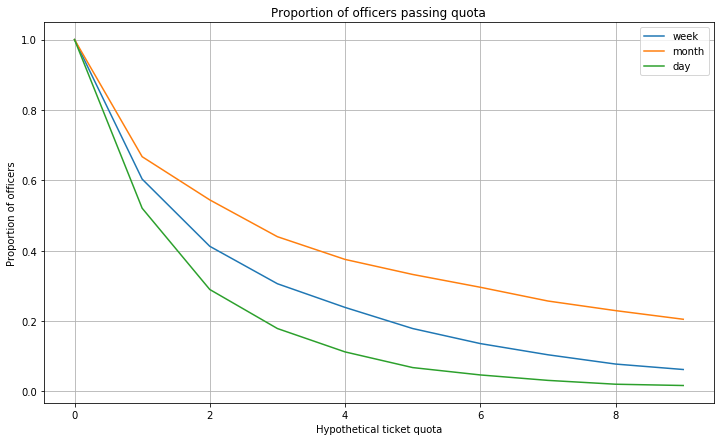

In [31]:
plt.plot(range(10), pass_list_week, label = 'week')
plt.plot(range(10), pass_list_month, label = 'month')
plt.plot(range(10), pass_list_day, label = 'day')
plt.grid()
plt.title('Proportion of officers passing quota')
plt.ylabel('Proportion of officers')
plt.xlabel('Hypothetical ticket quota')
plt.legend()
plt.savefig(home_directory + '/results/passing_officers.png')
plt.show()

As we can see, the proportion drops off rapidly after the 1-ticket quota. If we assume that majority = 60%, the majority of police officers won't pass the traffic ticket quota when the quota is set to 2 tickets per day, per week or per month. 
Even if the quota was 1 per day, it would follow by linearity that officers would pass 7 per week or 30 per month, but none of those cases occur. 

### Creates interactive heatmap in an html file in the results folder.
#### Please input Google Maps API Key obtained from https://cloud.google.com/maps-platform/pricing/

In [32]:
latitudes = df_seattle[(df_seattle.citation_issued == True)].lat
longitudes = df_seattle[(df_seattle.citation_issued == True)].lng

# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(47.596971, -122.327652, 12)

# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Input API Key here
gmap.apikey = 'ENTER-API-KEY-HERE'

# Generate the heatmap into an HTML file
gmap.draw(home_directory + "/results/my_heatmap.html")

### Creating a dataframe grouped by weekday and plotting histogram

Text(0.5, 1.0, 'Citations per Weekday')

Text(0, 0.5, 'Citations Issued')

Text(0.5, 0, 'Day')

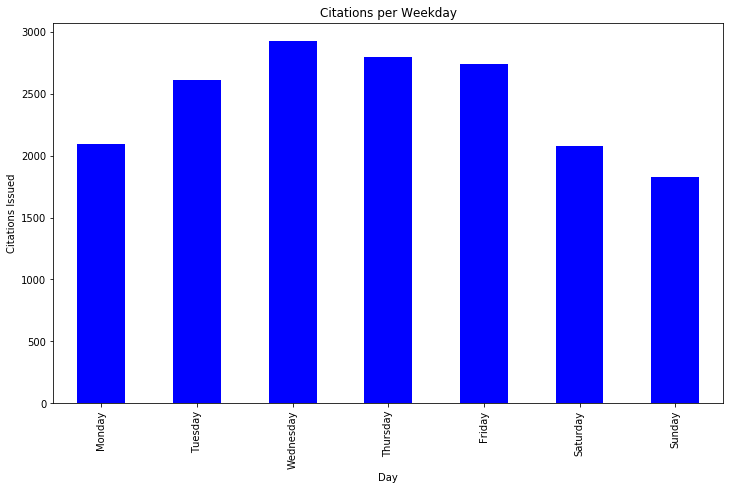

In [33]:
df_weekday = df_seattle[df_seattle.citation_issued == True].groupby(df_seattle.date.dt.weekday_name).count()
df_weekday = df_weekday.reindex(index = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax = df_weekday.citation_issued.plot(kind='bar', color='blue')
plt.title('Citations per Weekday')
plt.ylabel('Citations Issued')
plt.xlabel('Day')
plt.savefig(home_directory + '/results/Citations_per_weekday.png')
plt.show()

### Creating an hourly time series for displaying common hours for traffic stops

In [34]:
hourly_timeseries = df_seattle[df_seattle.citation_issued == True].groupby(pd.Grouper(key='time', freq='60min')).count()
hourly_timeseries.head()

,date,lat,lng,officer_id_hash,type,citation_issued,warning_issued,outcome,raw_type_description
time,,,,,,,,,
1900-01-01 00:00:00,864,864,864,864,864,864,864,864,864
1900-01-01 01:00:00,674,674,674,674,674,674,674,674,674
1900-01-01 02:00:00,417,417,417,417,417,417,417,417,417
1900-01-01 03:00:00,149,149,149,149,149,149,149,149,148
1900-01-01 04:00:00,411,411,411,411,411,411,411,411,411


Text(0.5, 1.0, 'Citations per hour')

Text(0, 0.5, 'Citations')

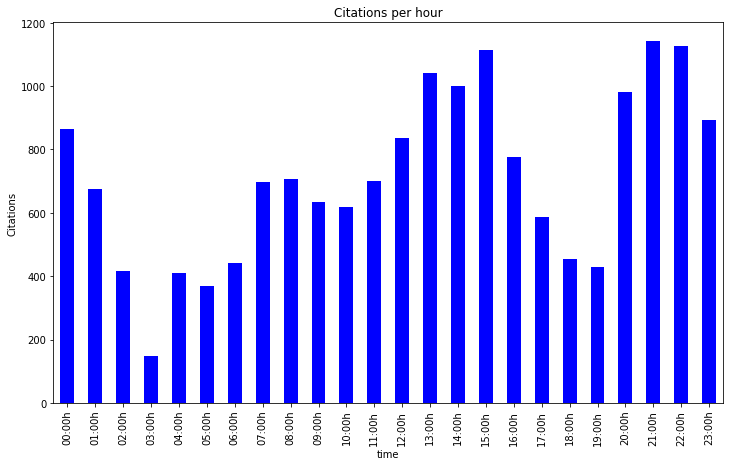

In [35]:
ax = hourly_timeseries.citation_issued.plot(kind='bar', color='blue')
ticklabels = hourly_timeseries.index.strftime('%H:%Mh')
ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
plt.title('Citations per hour')
plt.ylabel('Citations')
plt.savefig(home_directory + '/results/Citations_per_hour.png')
plt.show()

The most common times are from 1pm to 3pm and from 8pm to 1am. 